In [1]:
## IMPORTANT !

# In the first order need to set the number of CPU 
# for calculation before launching (depends on computer's number of cores)
n_jobs= 50
#libraries
import pandas as pd
import numpy as np
import os
import sys
import shutil
import glob
import joblib
import warnings
from datetime import date, datetime

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
import scipy.stats as st

from nilearn import image as nli
from nilearn import plotting

#from mne.viz import plot_connectivity_circle
from mne_connectivity.viz import plot_connectivity_circle

import copy

#%matplotlib inline
#import matplotlib_inline
#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

##### Path vars

In [2]:
path_ya = '/media/hcs-psy-narun/Alina/HCP_results/sep_2023_rerun_v5/hcp_ya/results/totalIQ/'
path_a = '/media/hcs-psy-narun/Alina/HCP_results/aug_rerun_v5/hcp_aging/results/totalIQ/'
path_d = '/media/hcs-psy-narun/Alina/HCP_results/aug_rerun_v5/dud_study/results/IQ45_adj/'
path_d_ch = '/media/hcs-psy-narun/Alina/HCP_results/aug_rerun_v5/dud_study/results/IQch_adj/'
path_d_res = '/media/hcs-psy-narun/Alina/HCP_results/aug_rerun_v5/dud_study/results/IQres_adj/'

In [3]:
path_ya_obs = '/media/hcs-psy-narun/Alina/ready_tables_new_enhanced_REST-acomcor/main_set/totalIQ/'
path_a_obs = '/media/data/HCPAging/data/New_MLTabs_OneTrain_latest_short/totalIQ/'
path_d_obs = '/media/data/Dunedin_Study_Data_Narun_P_Jan2022/New_MLTabs_OneTrain/main_set/IQ45_adj/'
path_d_ch_obs = '/media/data/Dunedin_Study_Data_Narun_P_Jan2022/New_MLTabs_OneTrain/main_set/IQch_adj/'
path_d_res_obs = '/media/data/Dunedin_Study_Data_Narun_P_Jan2022/New_MLTabs_OneTrain/main_set/IQres_adj/'

In [4]:
path_out = '/media/hcs-psy-narun/Alina/HCP_results/predicted_values_for_datasets_5/'

##### Load data

In [5]:
#load observed data
targ_obs = {}

for path, key in zip([path_ya_obs, path_a_obs, path_d_obs, path_d_ch_obs, path_d_res_obs],
                     ['YA', 'A', 'DUD', 'DUD_ch', 'DUD_res']):
    targ = {}
    for fold in sorted(os.listdir(path)):
        targ[fold] = pd.read_csv(glob.glob(path+fold+'/*_test*')[0], index_col=0)
    
    targ_obs[key] = targ

In [7]:
#load predicted data
layer1 = {}
layer2 = {}

for path_obs, key, path in zip([path_ya_obs, path_a_obs, path_d_obs, path_d_ch_obs, path_d_res_obs],
                               ['YA', 'A', 'DUD', 'DUD_ch', 'DUD_res'],
                               [path_ya, path_a, path_d, path_d_ch, path_d_res]):
    l1={}
    l2={}
    for fold in sorted(os.listdir(path_obs)):
        l1[fold] = {}
        l2[fold] = {}
        for file in sorted(glob.glob(path+'layer1/*/*/'+fold+'/test_results.csv')):
            l1[fold][file.split('/')[-4]+'_'+file.split('/')[-3]] = pd.read_csv(file, index_col=0, squeeze=True)
        for file in sorted(glob.glob(path+'layer2/*/*/*/'+fold+'/test_results.csv')):
            l2[fold][file.split('/')[-5]+'_'+file.split('/')[-4]+'_'+file.split('/')[-3]] = pd.read_csv(file, index_col=0, squeeze=True)
    layer1[key] = l1
    layer2[key] = l2

In [9]:
#combime layers into one tab
val_pred = {}

for path_obs, KEY in zip([path_ya_obs, path_a_obs, path_d_obs, path_d_ch_obs, path_d_res_obs],
                         ['YA', 'A', 'DUD', 'DUD_ch', 'DUD_res']):
    
    tab_val = pd.DataFrame()
    
    for fold in sorted(os.listdir(path_obs)):
        
        a = pd.DataFrame(layer1[KEY][fold])
        b = pd.DataFrame(layer2[KEY][fold])
        ab = pd.concat([a, b], axis=1)
        ab['y_obs'] = targ_obs[KEY][fold].values.ravel()
        ab['fold'] = np.full(targ_obs[KEY][fold].values.ravel().shape, fold)
        ab.index = targ_obs[KEY][fold].index
        
        tab_val = pd.concat([tab_val, ab], axis=0)
    
    val_pred[KEY] = tab_val

##### Calculate indexes across the folds

In [10]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

R2 = {}
MAE = {}
COR = {}
Results = {}

for path_obs, KEY, path in zip([path_ya_obs, path_a_obs, path_d_obs, path_d_ch_obs, path_d_res_obs],
                               ['YA', 'A', 'DUD', 'DUD_ch', 'DUD_res'],
                               [path_ya, path_a, path_d, path_d_ch, path_d_res]):


    #calculate indexes
    r2 = {}
    mae = {}
    corr = {}

    for fold in sorted(os.listdir(path_obs)):
        #print(fold)
        r2[fold] = {}
        mae[fold] = {}
        corr[fold] = {}
        for key in layer1[KEY][fold].keys():
            #print(key)
            r2[fold][key] = r2_score(targ_obs[KEY][fold], layer1[KEY][fold][key])
            mae[fold][key] = mean_absolute_error(targ_obs[KEY][fold], layer1[KEY][fold][key])
            corr[fold][key] = pearsonr(targ_obs[KEY][fold].values.ravel(), layer1[KEY][fold][key].values.ravel())[0]    
        for key in layer2[KEY][fold].keys():
            #print(key)
            r2[fold][key] = r2_score(targ_obs[KEY][fold], layer2[KEY][fold][key])
            mae[fold][key] = mean_absolute_error(targ_obs[KEY][fold], layer2[KEY][fold][key])
            corr[fold][key] = pearsonr(targ_obs[KEY][fold].values.ravel(), layer2[KEY][fold][key].values.ravel())[0]       
    r2 = pd.DataFrame(r2)        
    mae = pd.DataFrame(mae)
    corr = pd.DataFrame(corr)

    results = pd.DataFrame({'r2':r2.T.mean(),
                            'mae':mae.T.mean(),
                            'corr':corr.T.mean()})
    
    R2[KEY] = r2
    MAE[KEY] = mae
    COR[KEY] = corr
    Results[KEY] = results
    

##### Save

In [11]:


for KEY in ['YA', 'A', 'DUD', 'DUD_ch', 'DUD_res']:
    
    R2[KEY].to_csv(path_out+'R2_'+KEY+'.csv')
    MAE[KEY].to_csv(path_out+'MAE_'+KEY+'.csv')
    COR[KEY].to_csv(path_out+'COR_'+KEY+'.csv')
    Results[KEY].to_csv(path_out+'Results_mean_'+KEY+'.csv')
    val_pred[KEY].to_csv(path_out+'pred_vals_'+KEY+'.csv')

##### Assign the labels

In [13]:
#
YA_s = ['Total Brain Volume',
        'Cortical Thickness',
        'Emotion Processing Contrast',
        'Gambling Contrast',
        'Gambling FC',
        'Language Contrast',
        'Language FC',
        'Motor Contrast', 
        'Motor FC',
        'Relational Contrast',
        'Relational FC',
        'Resting State FC', 
        'Social Cognition Contrast',
        'Social Cognition FC',
        'Subcortical Volume',
        'Surface Area', 
        'Working Memory Contrast',
        'Working Memory FC']

YA_st = ['Stacked: All', #1
         'Stacked: Task Contrast',         #2
         'Stacked: Non Task', #3
         'Stacked: Task FC',#4
         'Stacked: Task Contrast & Task FC',#5
         'Stacked: All excluding Task FC',#6
         'Stacked: All excluding Task Contrast',#7
         'Stacked: Resting and Task FC']#8 

A_s = ['Total Brain Volume',
       'CARIT Contrast', #1    
       'CARIT FC',    
       'Cortical Thickness',    
       'Facename: Encoding-Recall',#4
       'Facename: Encoding-Distractor',#5
       'Facename: Recall-Distractor',#6    
       'Facename FC',
       'Resting State FC',
       'Subcortical Volume', 
       'Cortical Surface', 
       'Vismotor Contrast',
       'Vismotor FC']
         
A_st = ['Stacked: All', #set1
        'Stacked: Task Contrast', #set2
        'Stacked: Non Task', #set3
        'Stacked: Task FC', #set4
        'Stacked: Task Contrast & Task FC', #set5
        'Stacked: All excluding Task FC', #set6  with Task GLM
        'Stacked: All excluding Task Contrast',  #set7 with Task FC
        'Stacked: Resting and Task FC'] #set8

DUD_s = ['Total Brain Volume',
         'Cortical Thickness',    
         'Facename: Encoding-Distractor',    
         'Facename FC',    
         'Emotion Processing Contrast', 
         'Emotion Processing FC', 
         'MID Contrast', 
         'MID FC', 
         'Resting State FC',  
         'Stroop Contrast',
         'Stroop FC',
         'Subcortical Volume',
         'Surface Area']
 
DUD_st = ['Stacked: All', #1
          'Stacked: Task Contrast', #2
          'Stacked: Non Task',#3
          'Stacked: Task FC',#4
          'Stacked: Task Contrast & Task FC',#5
          'Stacked: All excluding Task FC',#6
          'Stacked: All excluding Task Contrast',#7
          'Stacked: Resting and Task FC']#8

In [14]:
lbl_YA, lbl_A, lbl_DUD = [], [], []
algs = ['eNet', 'RF', 'SVR', 'XGB']
for single, stack, labels in zip([YA_s, A_s,DUD_s],[YA_st, A_st,DUD_st], [lbl_YA, lbl_A, lbl_DUD]):
        
    for i in algs:
        for lbl in single:
            labels+= [lbl+', '+i]

    for i in algs:    
        for j in algs:
            for lbl in stack:
                labels+= [lbl+', '+i+'+'+j]

In [15]:
for KEY in ['YA', 'A', 'DUD', 'DUD_ch', 'DUD_res']:
    
    if KEY=='YA':
        lblss = lbl_YA
    if KEY=='A':
        lblss = lbl_A   
    if KEY in [ 'DUD', 'DUD_ch', 'DUD_res']:
        lblss = lbl_DUD
    R2[KEY].index = lblss
    MAE[KEY].index = lblss
    COR[KEY].index = lblss
    Results[KEY].index = lblss

##### Plotting

##### plot the main combination (same alg on 1 and 2 layers)

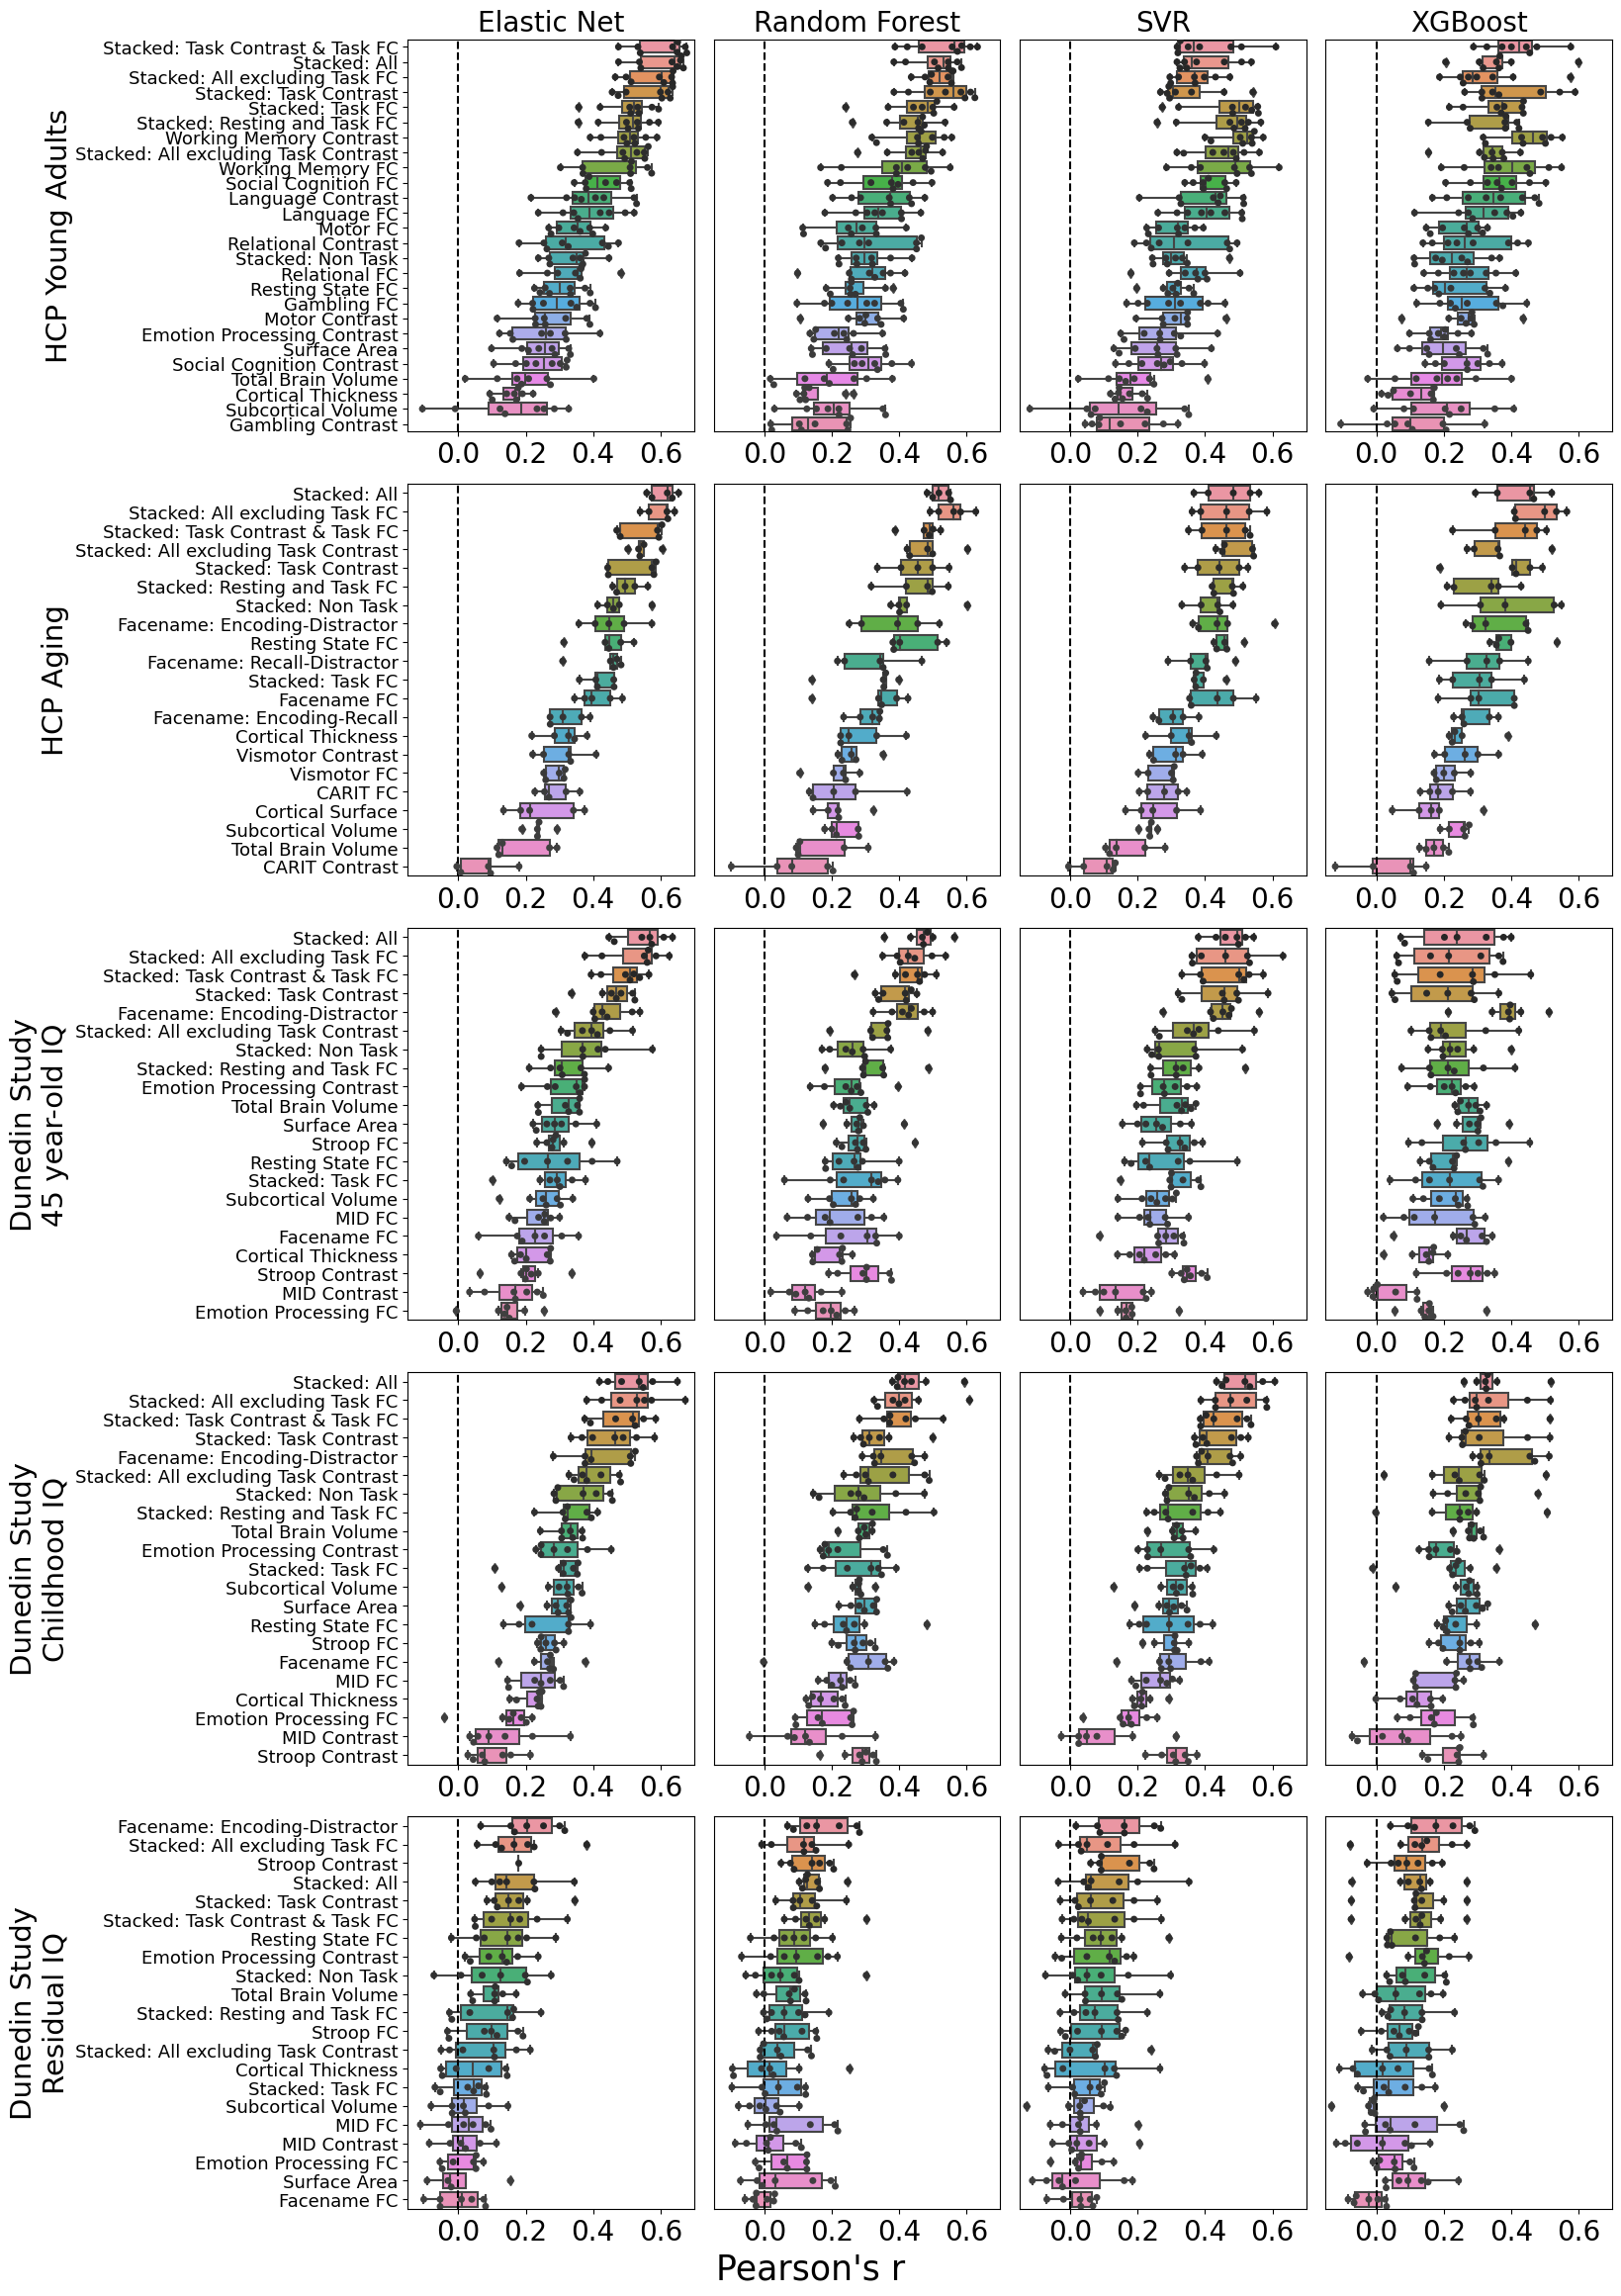

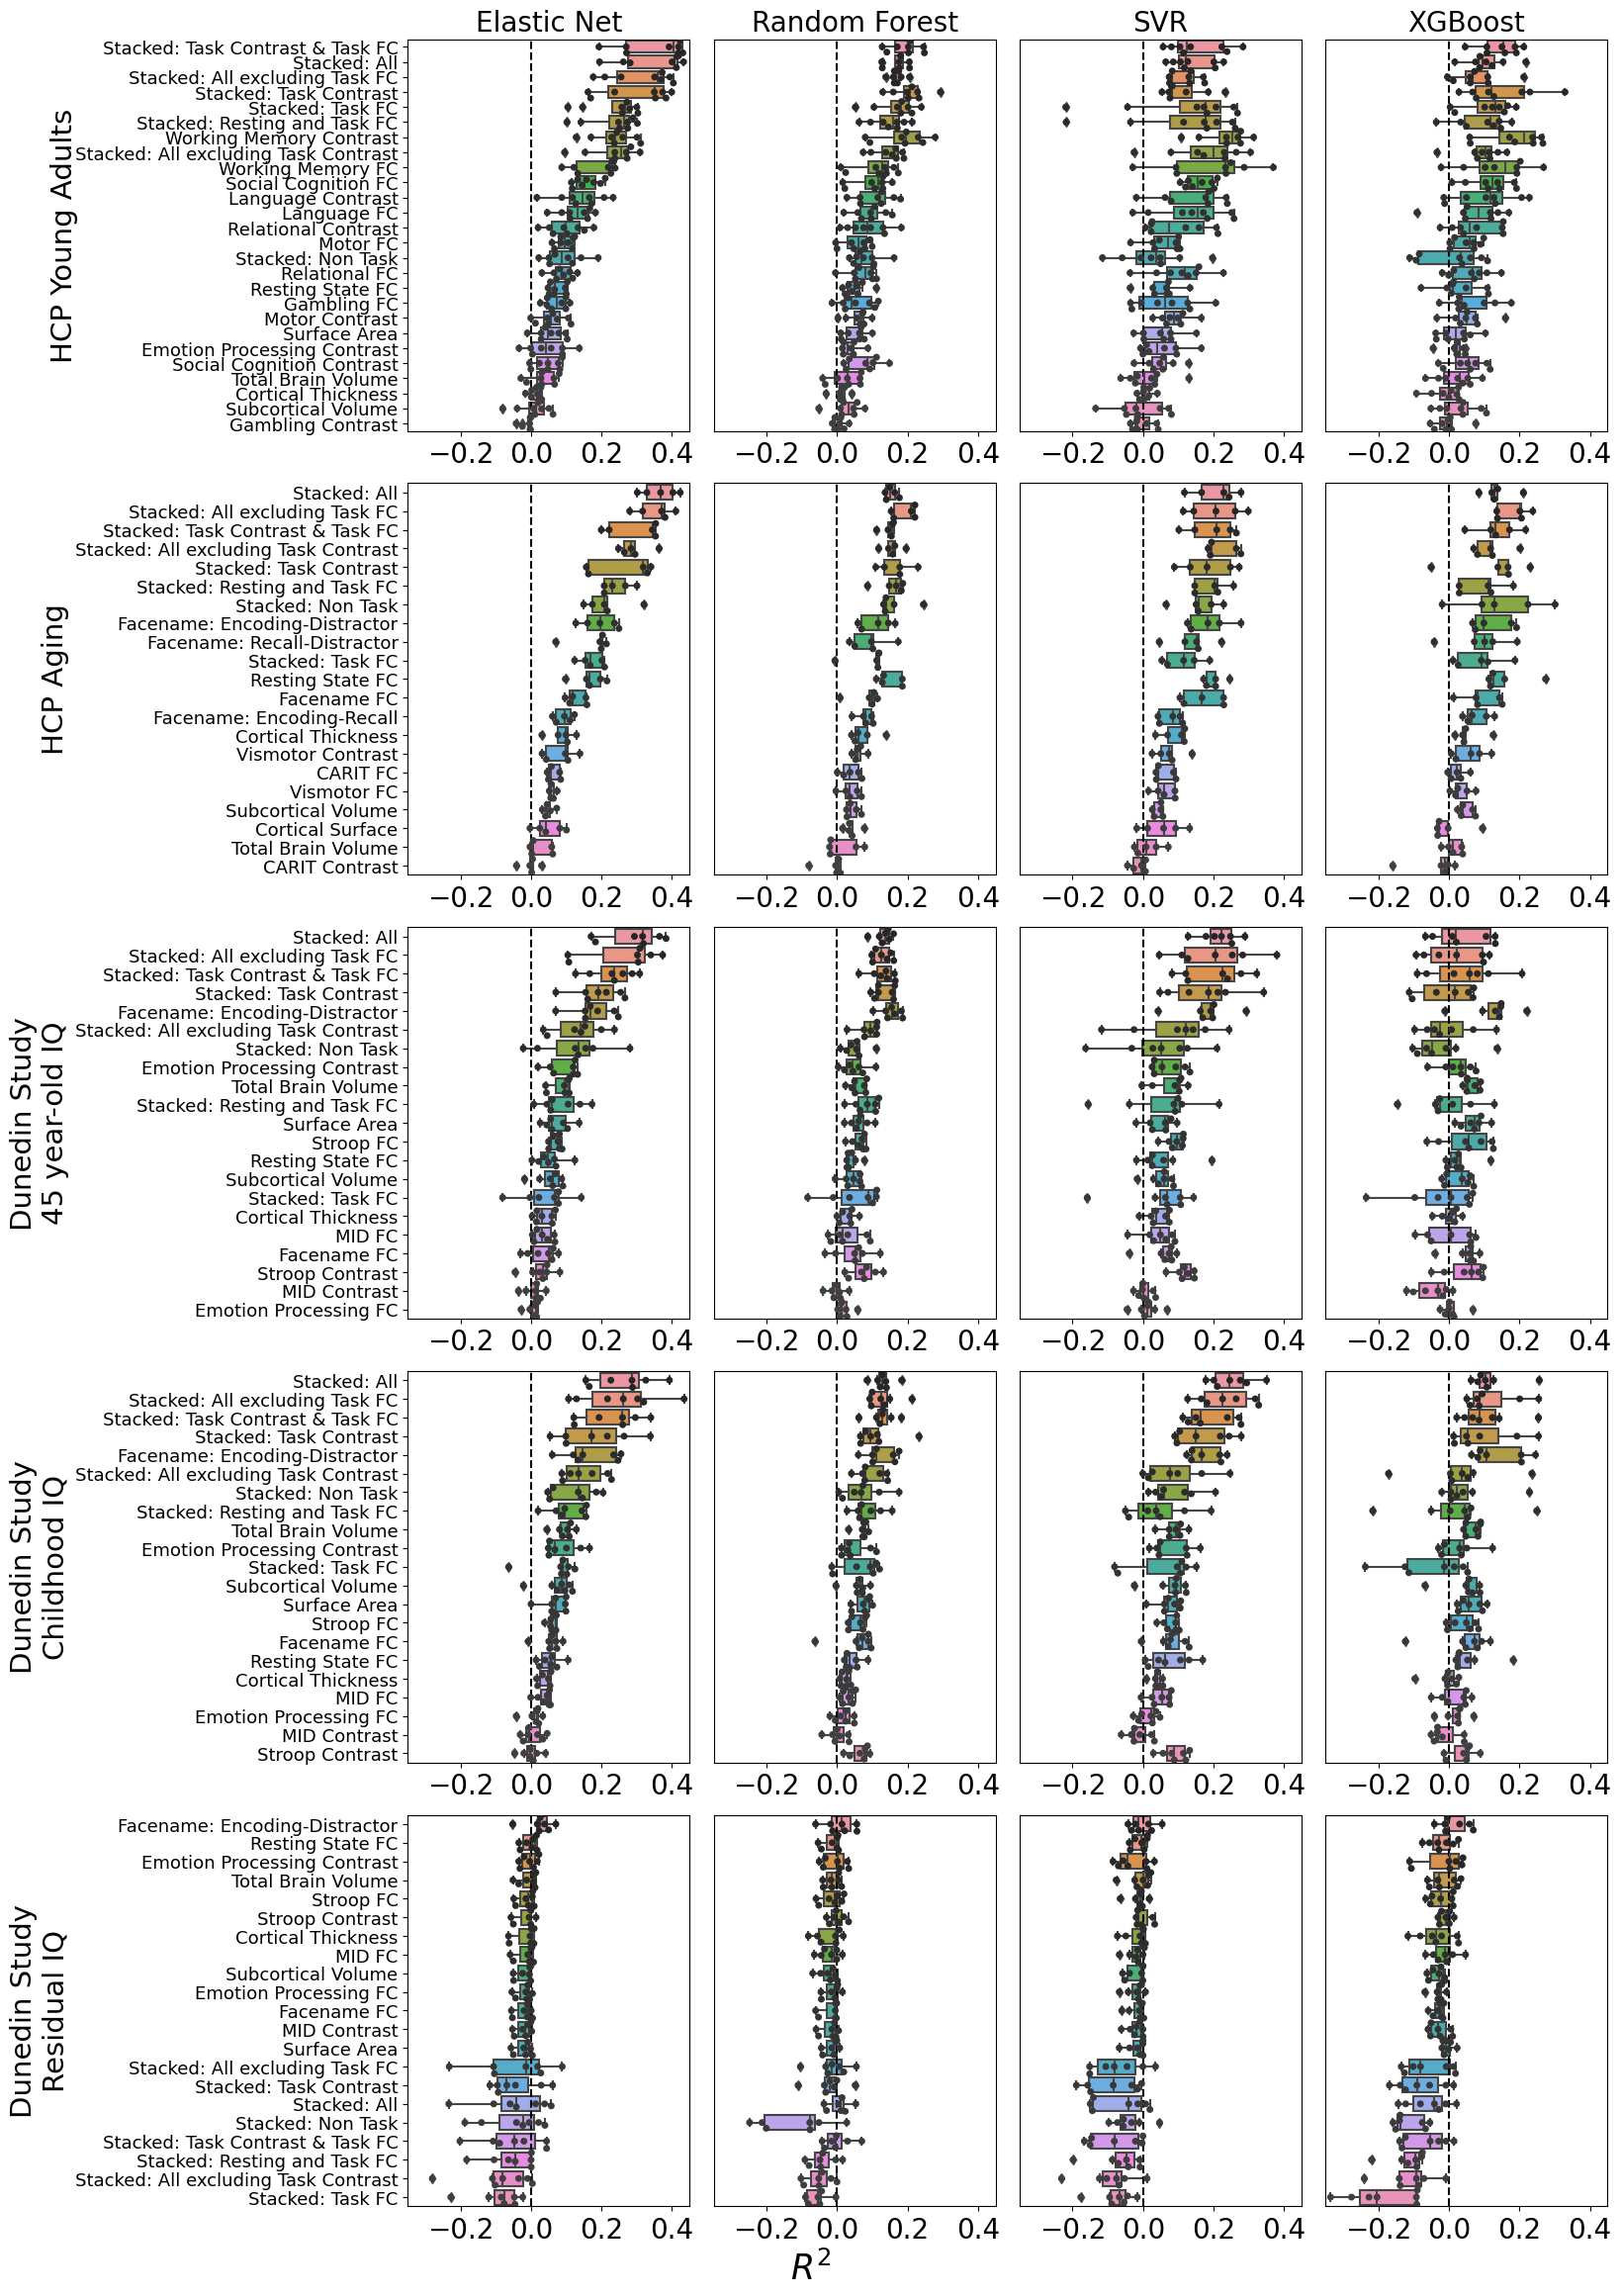

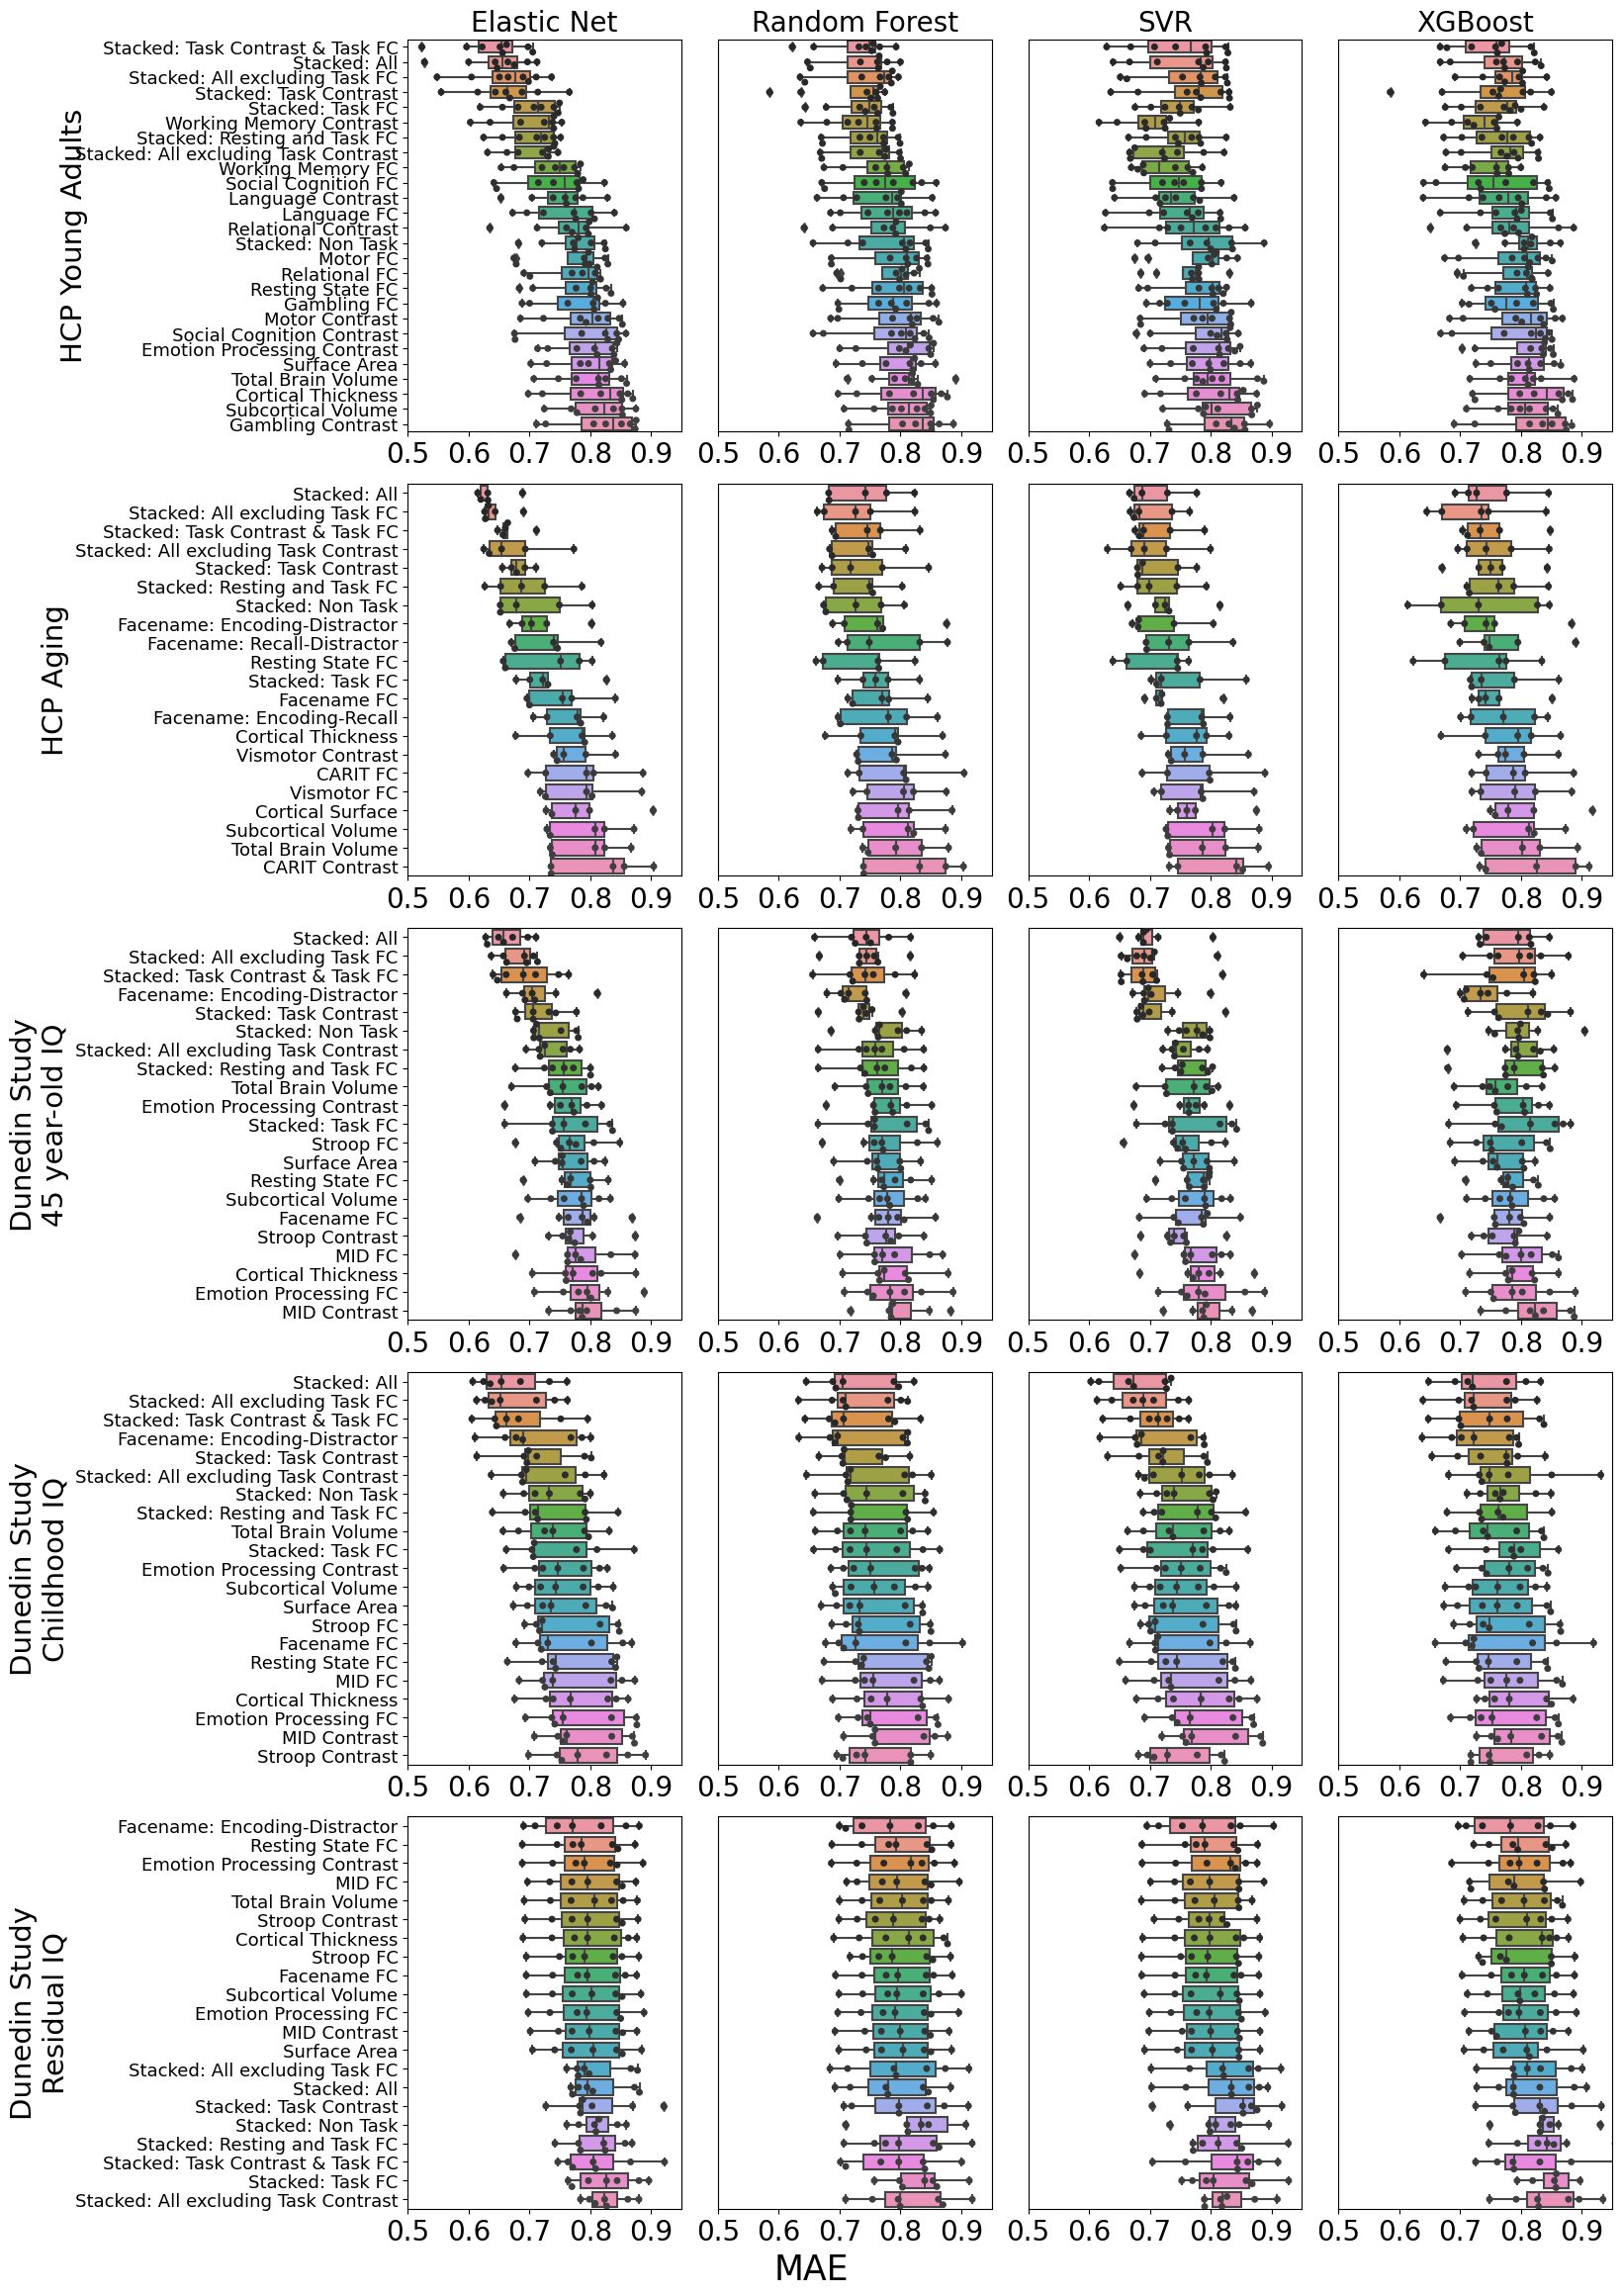

In [16]:
for mlindex, mlindex_title, mlkey in zip([COR, R2, MAE], ["Pearson's r", '$R^2$', 'MAE'], ['COR', 'R2', 'MAE']):
    





    fig = plt.figure(figsize=(16.5,23.4))
    i=1
    algs = ['eNet', 'RF', 'SVR', 'XGB']
    algs_nm = ['Elastic Net', 'Random Forest', 'SVR', 'XGBoost']


    for KEY, KEY_dn in zip(['YA', 'A', 'DUD', 'DUD_ch', 'DUD_res'],['HCP Young Adults',
                                                                    'HCP Aging',
                                                                    'Dunedin Study\n45 year-old IQ',
                                                                    'Dunedin Study\nChildhood IQ',
                                                                    'Dunedin Study\nResidual IQ']):

        vec_alg = copy.deepcopy(algs)

        for alg,alg_nm  in zip(algs, algs_nm):
            vec_alg = copy.deepcopy(algs)
            vec_alg.remove(alg)

            lbls_alg = [i for i in Results[KEY].index if alg in i and (vec_alg[0] not in i and vec_alg[1] not in i and vec_alg[2] not in i) ]
            
            if mlkey == 'MAE':
                ascending = True
            else:
                ascending = False
            
            data = mlindex[KEY].reindex(index= mlindex[KEY].reindex(index=lbls_alg).T.mean().sort_values(ascending=ascending).index ).T

            data.columns = [i.split(',')[0] for i in data.columns]

            if alg == 'eNet':
                alg_enet_lbl = data.columns
                alg_enet_lbl = [i.split(',')[0] for i in alg_enet_lbl]

            data = data.reindex(columns = alg_enet_lbl)



            plt.subplot(5,4,i)

            ax = sns.boxplot(data=data, orient="h")
            ax = sns.swarmplot(data=data, color=".25", orient="h")
            plt.axvline(x=0, c='black', linestyle='--')

            if i not in [1,5,9,13,17]:
                plt.yticks([])
            else:
                plt.yticks(fontsize=13)

            if i in [1,5,9,13,17]:
                #plt.ylabel(KEY, fontsize=21)
                ax.set_ylabel(KEY_dn, fontsize=21) #ha='left',rotation=90,
                if KEY=='YA':
                    ax.set_ylabel(KEY_dn, fontsize=21) # loc='center', ha='left',rotation=90,
                    ax.yaxis.set_label_coords(x=-1.17, y=0.5)

            plt.xticks(fontsize=20) 

            if mlkey == 'COR':
                plt.xlim((-0.15,0.7))
            if mlkey == 'R2':
                plt.xlim((-0.35,0.45))
            if mlkey == 'MAE':
                plt.xlim((0.5,0.95))

            if i in np.arange(1,5,1):
                plt.title(alg_nm ,fontsize=20)

            i+=1

    fig.supxlabel(mlindex_title, fontsize=25)
    fig.tight_layout()   
    plt.savefig(path_out+mlkey+'_plot_image.svg')
    plt.show()

##### plot the supplementary combinations (different algs on 1 and on 2 layers)

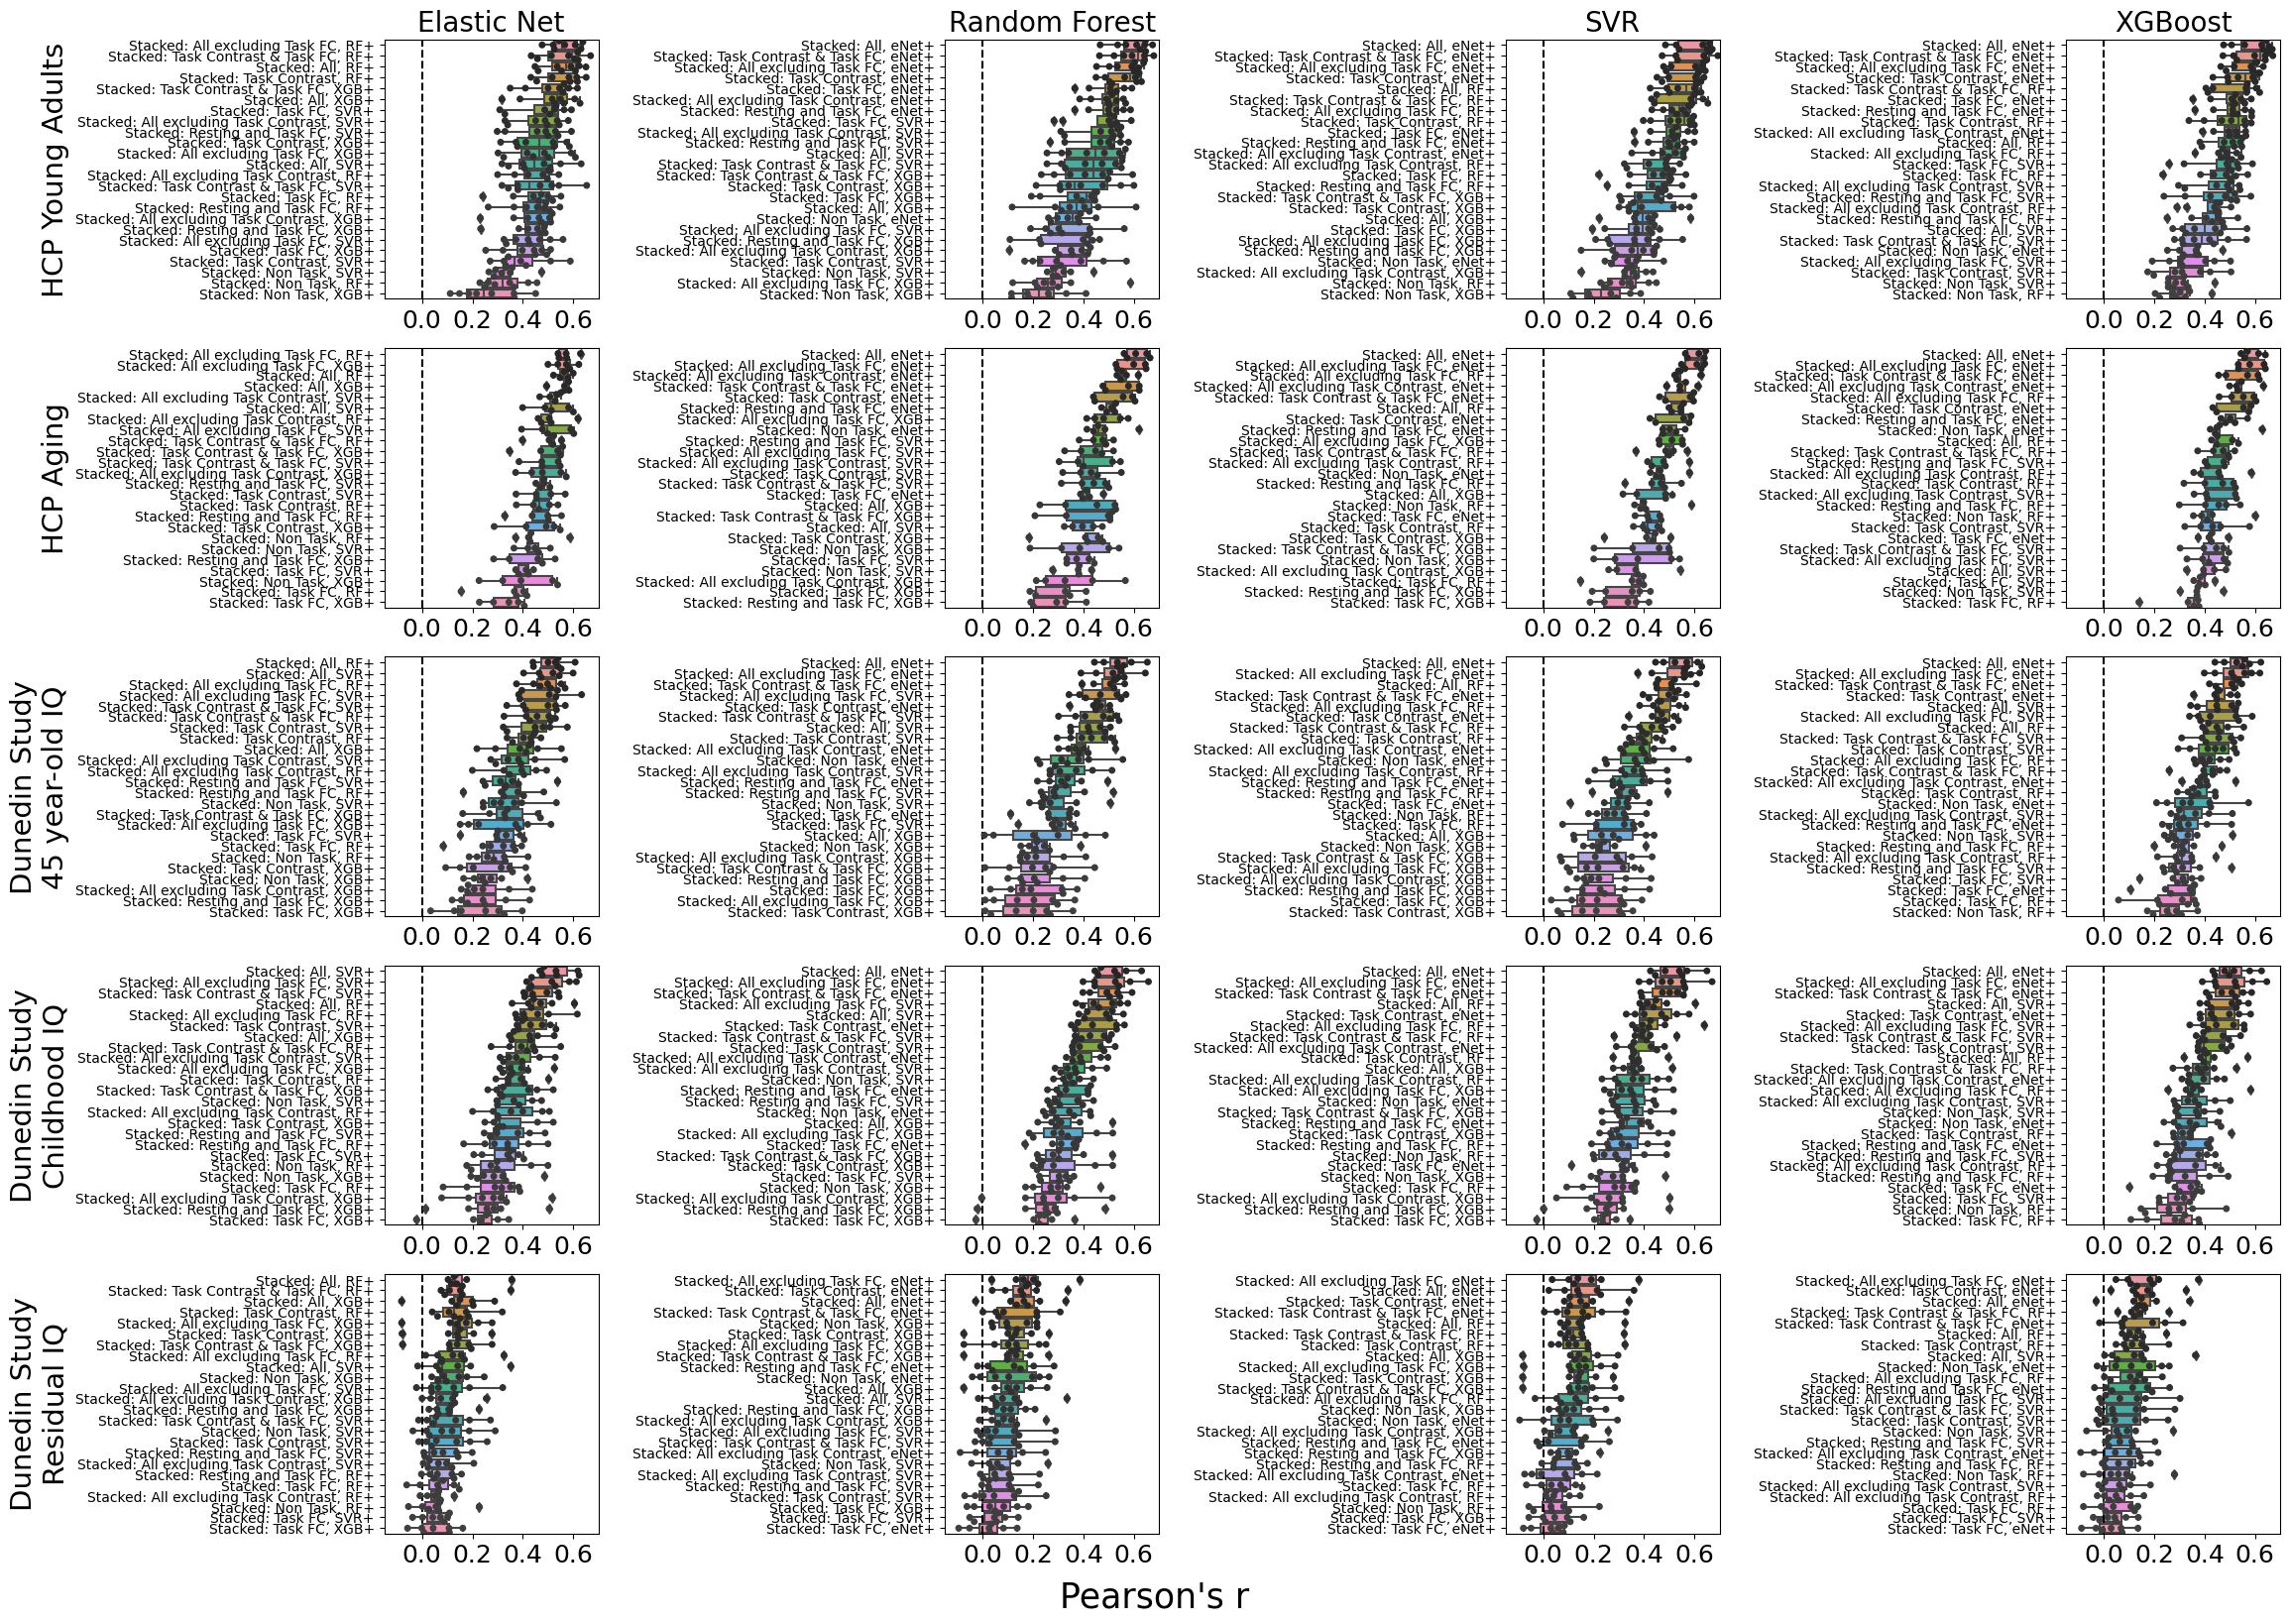

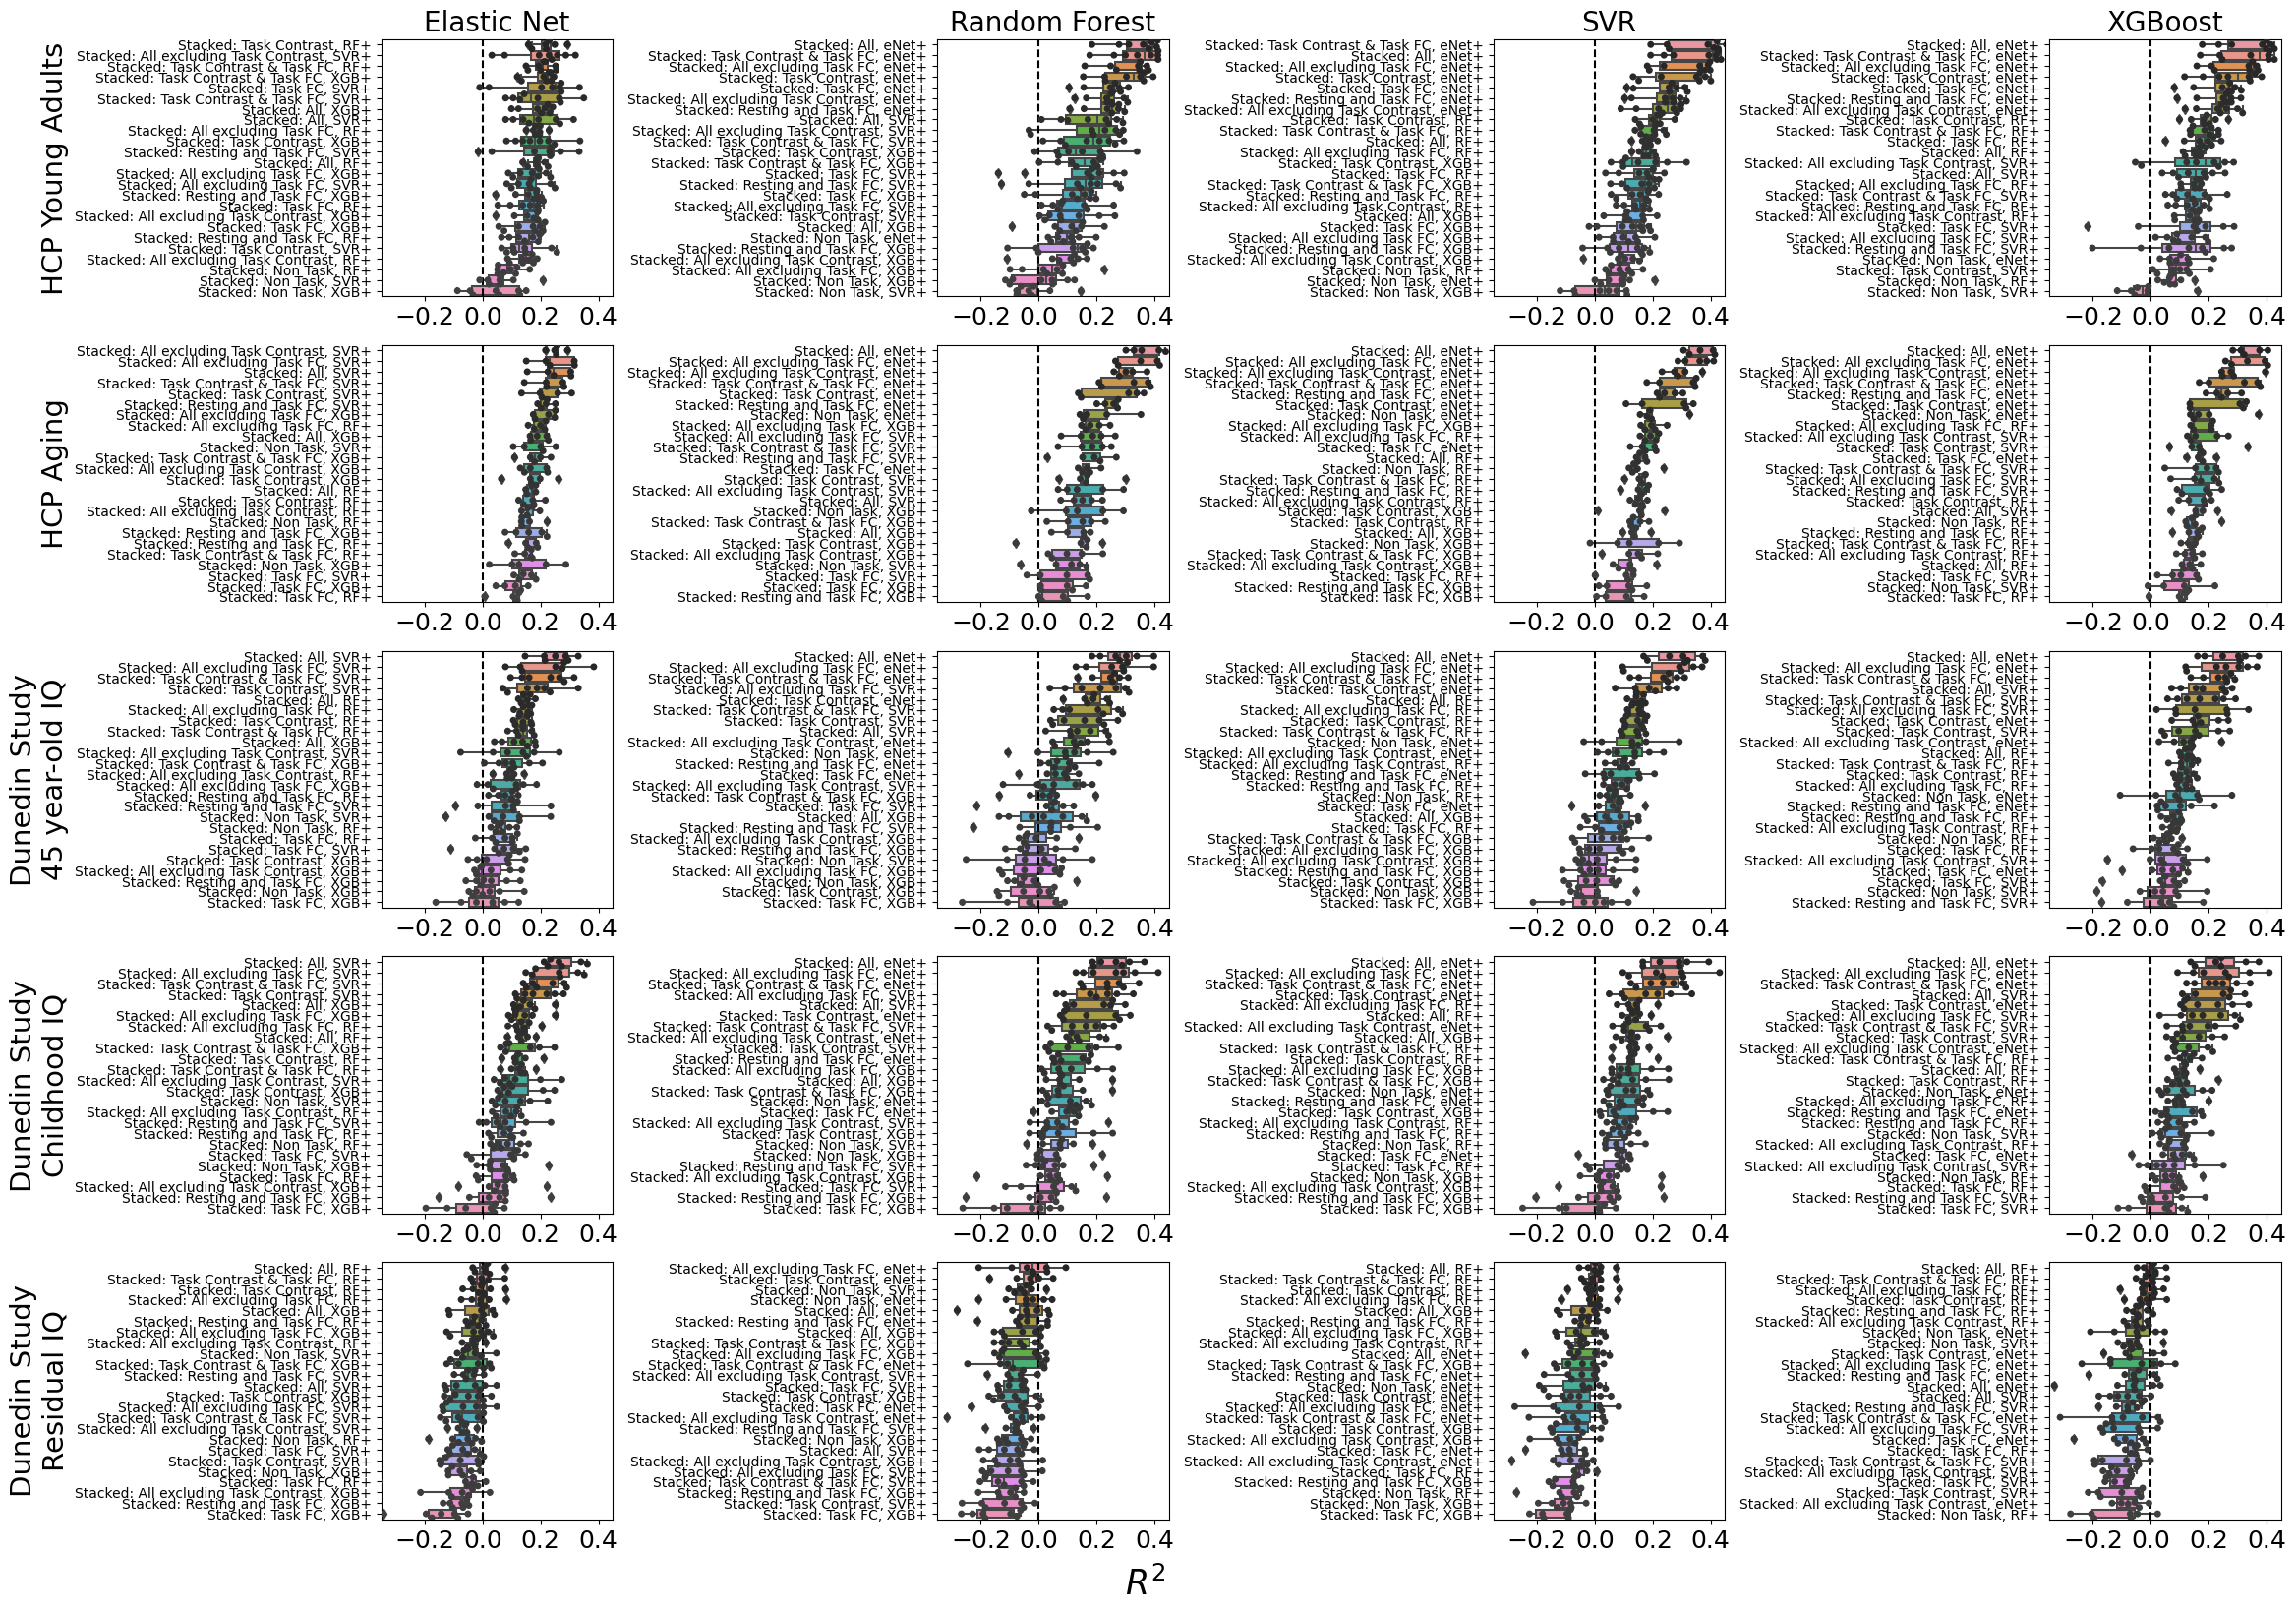

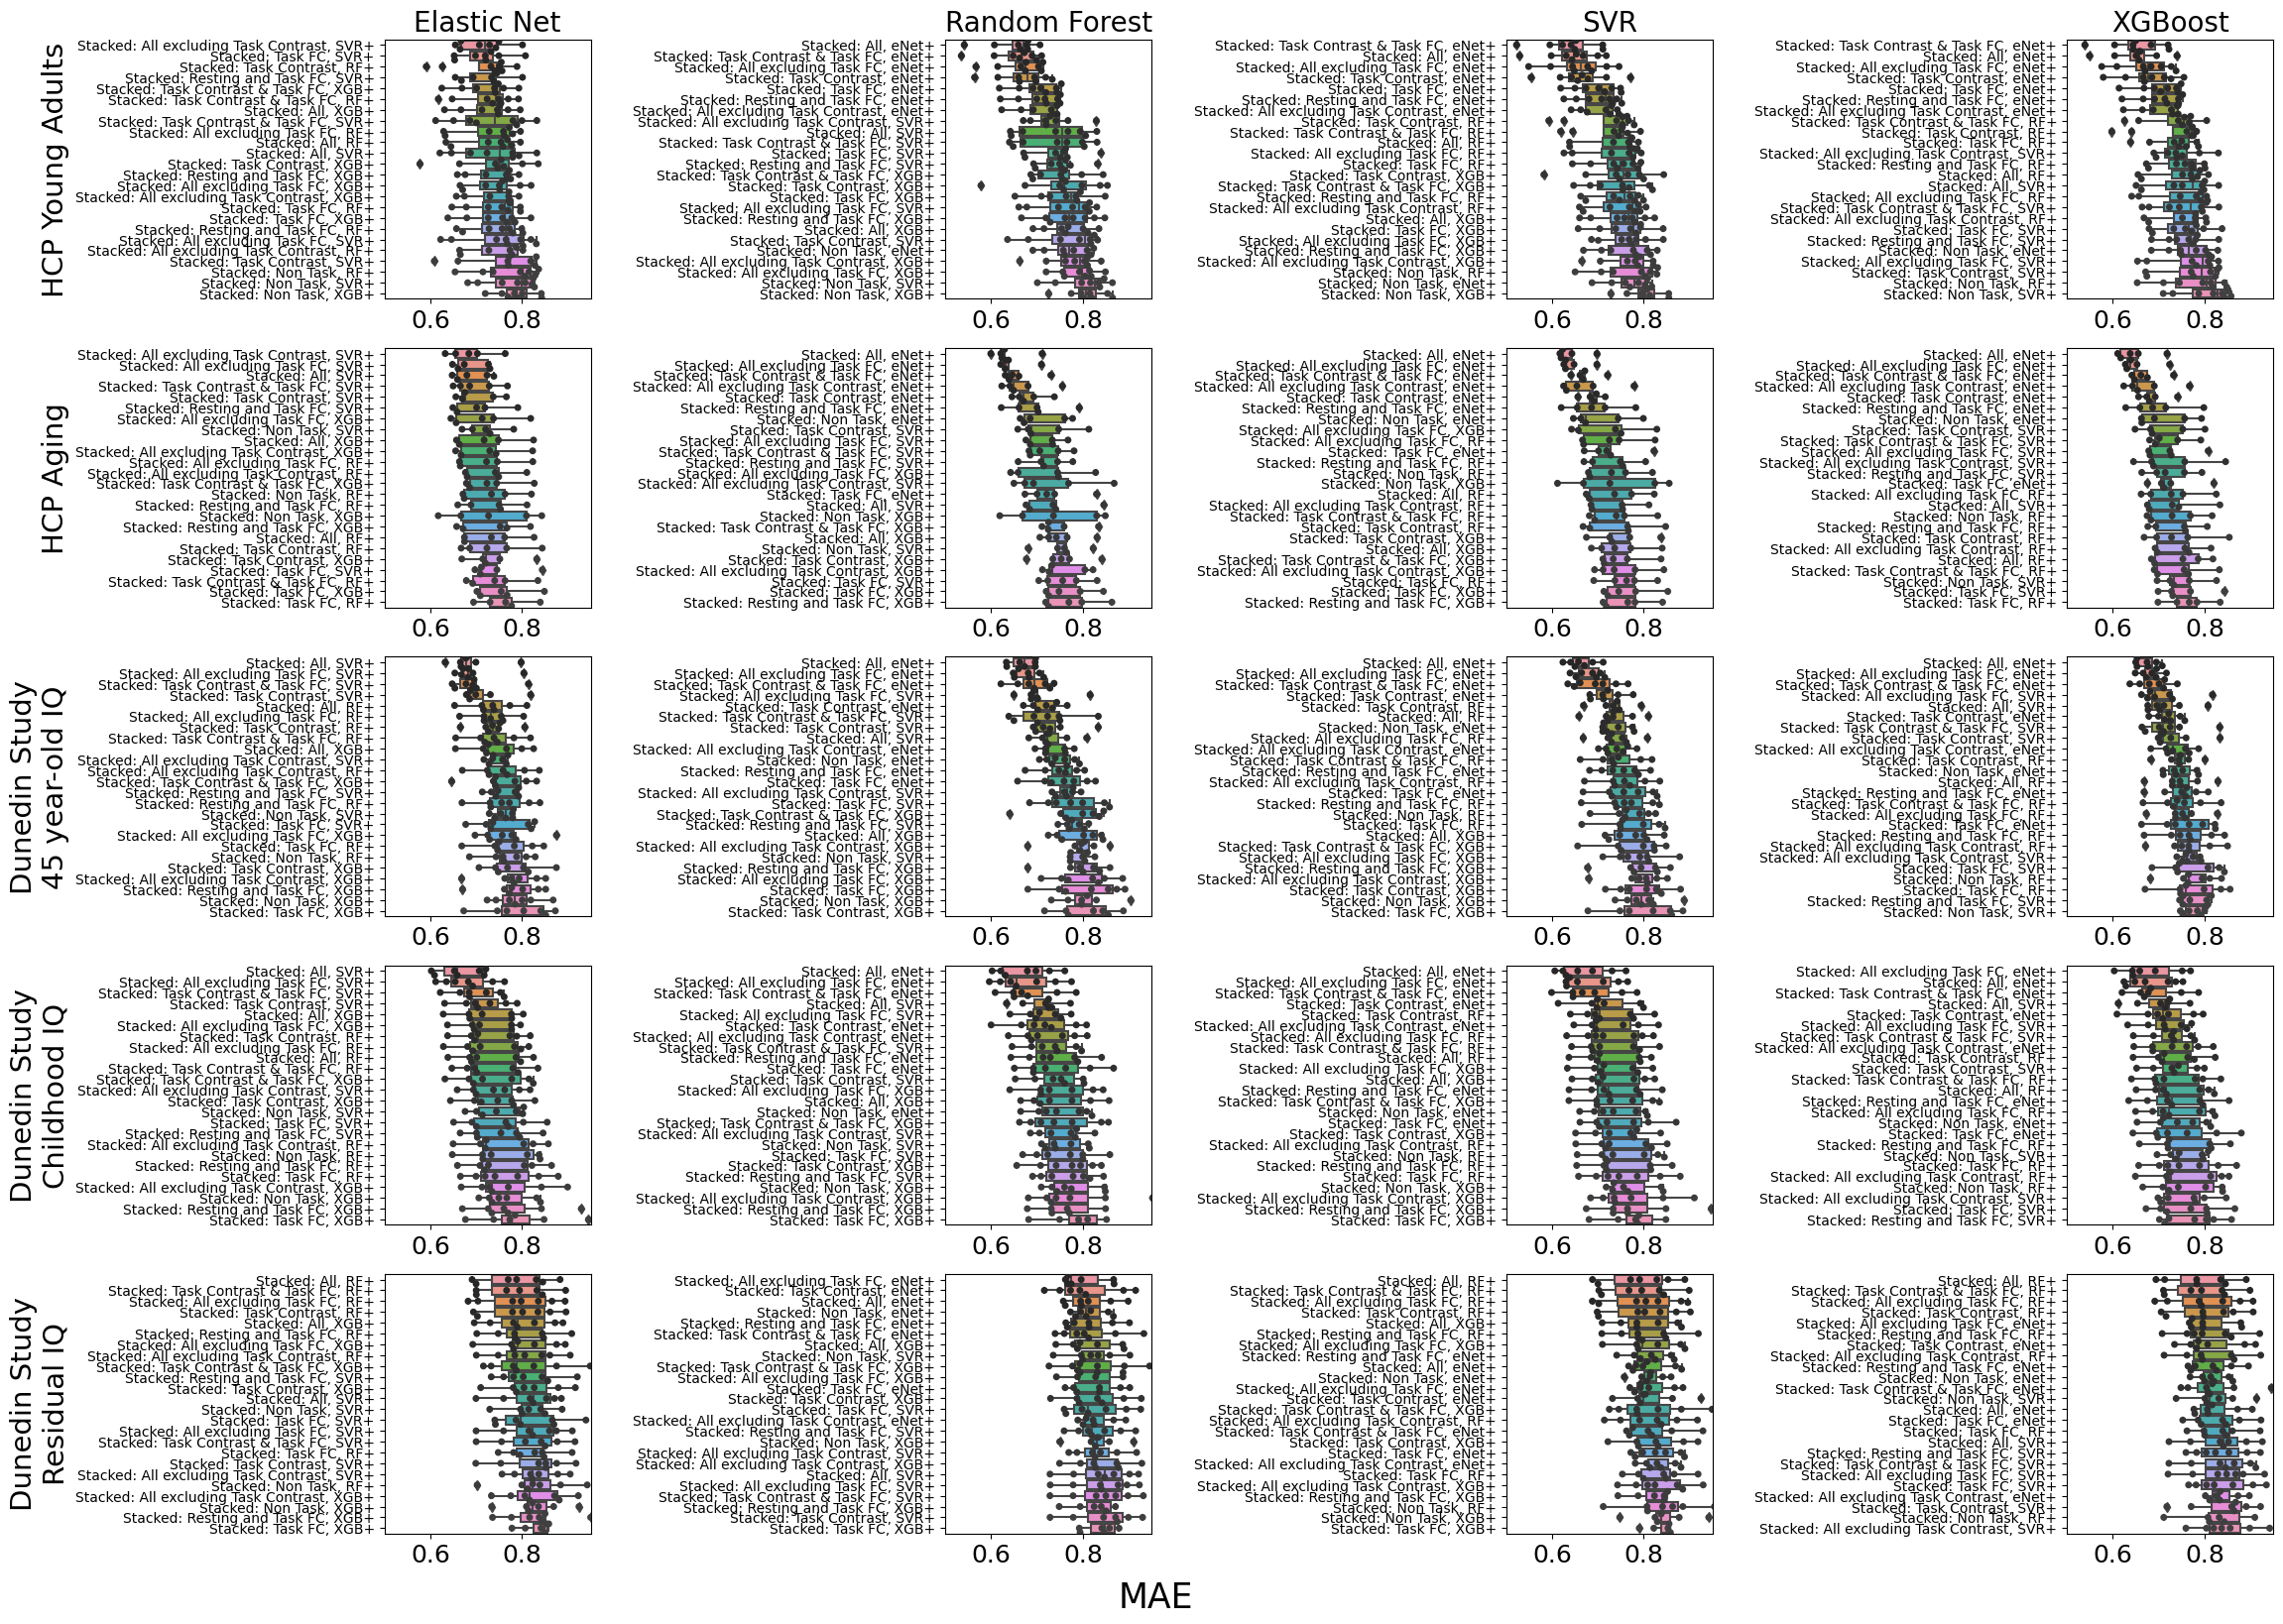

In [17]:
for mlindex, mlindex_title, mlkey in zip([COR, R2, MAE], ["Pearson's r", '$R^2$', 'MAE'], ['COR', 'R2', 'MAE']):
    

    fig = plt.figure(figsize=(23.4,16.5))
    i=1
    algs = ['eNet', 'RF', 'SVR', 'XGB']
    algs_nm = ['Elastic Net', 'Random Forest', 'SVR', 'XGBoost']


    for KEY, KEY_dn in zip(['YA', 'A', 'DUD', 'DUD_ch', 'DUD_res'],['HCP Young Adults',
                                                                    'HCP Aging',
                                                                    'Dunedin Study\n45 year-old IQ',
                                                                    'Dunedin Study\nChildhood IQ',
                                                                    'Dunedin Study\nResidual IQ']):

        vec_alg = copy.deepcopy(algs)

        llist=[]

        for alg in algs:
            vec_alg = copy.deepcopy(algs)
            vec_alg.remove(alg)

            lbls_alg = [i for i in Results['YA'].index if alg in i and (vec_alg[0] not in i and vec_alg[1] not in i and vec_alg[2] not in i) ]
            llist.extend(lbls_alg)
        vvec = [i for i in Results['YA'].index if i not in llist]

        for alg,alg_nm  in zip(algs, algs_nm):
            rlabel = [i for i in vvec if '+'+alg in i]

            if mlkey == 'MAE':
                ascending = True
            else:
                ascending = False
            
            
            data = mlindex[KEY].reindex(index=mlindex[KEY].reindex(index=rlabel).T.mean().sort_values(ascending=ascending).index ).T

            data.columns = [i.split('+')[0]+'+' for i in data.columns]

            #if alg == 'eNet':
            #    alg_enet_lbl = data.columns

            #data = data.reindex(columns = alg_enet_lbl)



            plt.subplot(5,4,i)

            ax = sns.boxplot(data=data, orient="h")
            ax = sns.swarmplot(data=data, color=".25", orient="h")
            plt.axvline(x=0, c='black', linestyle='--')

            #if i not in [1,5,9,13,17]:
            #    plt.yticks([])
            #else:
            plt.yticks(fontsize=10)

            if i in [1,5,9,13,17]:
                #plt.ylabel(KEY, fontsize=21)
                ax.set_ylabel(KEY_dn,fontsize=21) #, ha='left',rotation=90
                if KEY=='YA':
                    ax.set_ylabel(KEY_dn, fontsize=21) #, ha='left',rotation=90,
                    #ax.yaxis.set_label_coords(x=-2, y=0.5)

            plt.xticks(fontsize=18) 

            if mlkey == 'COR':
                plt.xlim((-0.15,0.7))
            if mlkey == 'R2':
                plt.xlim((-0.35,0.45))
            if mlkey == 'MAE':
                plt.xlim((0.5,0.95))

            if i in np.arange(1,5,1):
                plt.title(alg_nm ,fontsize=20)

            i+=1

    fig.supxlabel(mlindex_title, fontsize=25)
    fig.tight_layout()   
    plt.savefig(path_out+mlkey+'_plot_image_supl.svg')
    plt.show()